<a href="https://colab.research.google.com/github/lastinm/ml_hw_notebooks/blob/main/%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C_4_AB_%D1%82%D0%B5%D1%81%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Чтение CSV файла напрямую из zip архива
ab_data = pd.read_csv('/content/drive/MyDrive/Data/ab_data.zip', compression='zip', header=0, sep=',')
ab_data.head()

In [ ]:
ab_data.info()

Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. Напомним: для этого мы можем воспользоваться функцией pandas to_datetime():

In [ ]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия.

Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий.

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [ ]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

Примечание. Количество пользователей в день в контрольной и тестовой группе определяется как количество значений в столбце user_id в сгруппированных данных, а количество совершённых целевых действий — это просто сумма по столбцу converted (1 в строке означает положительный исход, то есть целевое действие было совершено, а 0 — отрицательный исход; просуммировав все 1 и 0 в группе, получим количество положительных исходов).

Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %:

 — количество посетителей сайта, выполнивших целевое действие в день ;
 — общее количество посетителей сайта в день ;
 — конверсия в день .

In [ ]:
# Функция для расчета конверсии
def calculate_conversion(row):
    return (row['converted'] / row['users_count']) * 100

# Применяем функцию к каждой строке DataFrame
daily_data['conversion'] = daily_data.apply(calculate_conversion, axis=1)

In [ ]:
# Извлечение значения для группы A на 5 января 2017 года
result = daily_data.loc[(daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')]
result

In [ ]:
display(daily_data.head())

# ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный.

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам.

In [ ]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax)
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid(True);

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [ ]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %!

Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»?

Примечание. Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

Тут нам помогут кумулятивные метрики.

# КУМУЛЯТИВНЫЕ МЕТРИКИ

Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням.

Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

То есть в начале теста любой полученный за день результат будет оказывать сильное влияние на результат теста. Но со временем данные будут накапливаться, и доля получаемых за день данных будет всё меньше и меньше воздействовать на уже накопленный результат.

Примечание. Кумулятивная метрика считается стабилизированной, когда на графике прекращаются резкие пики и спады показателя, и линия постепенно выравнивается в горизонтальную прямую.

Важно! Принимать какие-либо решения стоит только после того, как метрика стабилизируется! Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему.

Примечание. В качестве кумулятивной метрики можно считать не только конверсию, но и выручку, средний чек, количество заказов, процент негативных комментариев, точность модели и так далее.

Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график.

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

In [ ]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group',
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача.

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А.

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [ ]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted).

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [ ]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

In [ ]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени.

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ КОНВЕРСИИ


Сначала подготовим данные к проведению статистических тестов. Для этого нам нужно рассчитать количество пользователей, совершивших конверсию, и общее количество пользователей в каждой контрольной и тестовой группах.

Cгруппируем таблицу ab_data по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы:

In [ ]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

Мы знаем, что группы независимые: пользователи в группах А и B не пересекаются. Значит, нам нужно воспользоваться либо Z- либо -критерием. Давайте рассмотрим тонкости применения обоих критериев.

# Z-ТЕСТ ДЛЯ ПРОПОРЦИЙ

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

Для получения p-value необходимо передать в функцию следующие аргументы:

count — количество «успехов» (в каждой из групп). В данном случае это количество пользователей, которые совершили целевое действие в каждой группе.

nobs — количество наблюдений (в каждой из групп), то есть размер выборки.

alternative — вид альтернативной гипотезы ('two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя). По умолчанию параметр равен 'two-sided'.

value — число, с которым сравнивается разница между двумя пропорциями. По умолчанию равно 0.

Примечание. Этот параметр может пригодиться, если необходимо проверить разницу между пропорциями на соответствие конкретному числу: например, гипотезы вида «Конверсия в группе A меньше, чем конверсия в группе B на 3 %». Тогда в качестве значения value можно установить число 0.03.

Примечание. Давайте вспомним, что:

Если полученное значение p-value ниже уровня значимости (), это означает, что результаты статистически значимы и согласуются с альтернативной гипотезой.
Если полученное значение p-value выше уровня значимости (), результаты считаются статистически незначимыми и нельзя отвергнуть нулевую гипотезу.

In [ ]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.19
# У нас нет оснований отвергнуть нулевую гипотезу

Итак, мы получили p-value = 0.19. Это больше, чем заданный уровень значимости 0.05, а значит, мы должны принять нулевую гипотезу о равенстве конверсий.

Что это значит для нас и для бизнеса?

Так как Z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза не подтверждается статистически.

Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии.

На основе этого вывода мы принимаем решение о том, что делать дальше.

Возможные варианты:

отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить текущую версию рекомендаций;
попытаться усовершенствовать модель и провести тестирование снова;
использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

А что, если мы хотим уточнить исследование и проверить гипотезу о том, что варианты А и B не просто идентичны между собой, а вариант А даже лучше варианта B по метрике конверсии? Тогда нам нужно переформулировать гипотезы таким образом, чтобы альтернативная гипотеза отражала наш бизнес-вопрос:

Нулевая (будет задавать отсутствие эффекта): конверсия в группе А меньше либо равна конверсии в группе B.


Альтернативная (будет задавать наличие эффекта): конверсия в группе А больше, чем конверсия в группе B.



Тогда код будет выглядеть следующим образом:

In [ ]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число «успехов»
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='larger' # правосторонняя альтернативная гипотеза
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.095
# У нас нет оснований отвергнуть нулевую гипотезу

Итак, p-value = 0.095 вновь больше, чем уровень значимости 0.05. А значит, что статистика говорит нам о том, что вариант A все таки не лучше, чем вариант B, что, в принципе, было ожидаемым из предыдущего тестирования о равенстве конверсий.

# ХИ-квадрат-ТЕСТ ДЛЯ ПРОПОРЦИЙ

Теперь давайте воспользуемся  -тестом для оценки разницы в пропорциях.

Этот тест основан на уже знакомом нам -критерии, который мы применяли для тестирования гипотезы о независимости двух категориальных признаков. Оказывается, этот же критерий с небольшими модификациями можно использовать и для установления статистической значимости разницы между пропорциями.

Этот тест применяется только для двусторонних гипотез:

Нулевая гипотеза: разница пропорций в группах A и B равна некоторому заранее заданному числу :


Альтернативная гипотеза: разница пропорций в группах A и B отлична от числа :



По умолчанию , соответственно, проверяется нулевая гипотеза равенства между истинными пропорциями  и  () против альтернативной гипотезы об их неравенстве ().

Тестом не предусмотрена возможность проверки односторонних гипотез.

-тест для пропорций реализован в функции proportions_chisquare() модуля proportion библиотеки statsmodels. Импортируем его:

In [ ]:
from statsmodels.stats.proportion import proportions_chisquare

Для получения хи2-статистики и p-value необходимо передать в функцию следующие аргументы:

count — количество «успехов» (в каждой из групп). В данном случае это количество пользователей, которые совершили целевое действие в каждой группе.
nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
value — число, с которым сравнивается разница между двумя пропорциями. По умолчанию равно 0.

Давайте применим -тест для пропорций на примере двух типов рекомендаций интернет-магазина с параметром value=0. То есть у нас будут две следующие конкурирующие гипотезы:

Нулевая (будет задавать отсутствие эффекта): конверсии в группах A и B равны.


Альтернативная (будет задавать наличие эффекта): конверсии в группах A и B не равны.



По умолчанию функция proportions_chisquare() возвращает -статистику, p-value и таблицу сопряжённости (используется во внутренних расчётах p-value). Из всего перечня возвращаемых значений нас интересует только p-value. Занесём его в отдельную переменную для дальнейшего сравнения с уровнем значимости.

Зададим уровень значимости  и будем сравнивать с ним полученное p-value.

In [ ]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'] #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value:  0.19
# У нас нет оснований отвергнуть нулевую гипотезу

Мы получили то же самое значение p-value, что и при тестировании гипотез с помощью Z-теста. Это неудивительно, ведь Z-критерий основан на нормальном распределении, а -критерий основан на -распределении, которое получается как сумма квадратов случайных величин, распределённых нормально.

То есть способы вычисления статистики для Z- и -критериев отличаются математически, однако при большом количестве наблюдений p-value для этих критериев будут совпадать.

Итак, согласно критерию хи2, у нас нет оснований отвергнуть нулевую гипотезу, а значит, мы в очередной раз подтвердили, что разницы между рекомендациями по метрике конверсии нет.

Отсюда возникает закономерный вопрос: какой из критериев использовать?

Если есть две независимых выборки и необходимо проверить равенство пропорций в них, то можно использовать Z-критерий для пропорций или -критерий для пропорций.

* Если объём выборок достаточно большой (обычно больше 30 наблюдений в каждой

группе), то оба критерия дают сравнимые результаты. В противном случае рекомендуется применять  для пропорций.

Также в литературе часто указывают, что при маленьких частотах в группах (менее пяти наблюдений в каждой ячейке таблицы сопряжённости) вместо -критерия рекомендуется применять точный критерий Фишера. Однако в реальных задачах A/B-тестирования стараются не применять тест на маленьких выборках, чтобы избежать эффекта подглядывания, поэтому тест Фишера вам вряд ли пригодится.

* Если по каким-то причинам нельзя обеспечить независимость групп, можно использовать критерий Мак-Немара. Однако он подходит только для парных данных, то есть каждому наблюдению в одной выборке должно соответствовать наблюдение в другой выборке.

** Примечание. ** Важно отметить, что тесты для пропорций можно применять не только к конверсии. Они подойдут для любых бизнес-метрик, которые отражают некоторые долевые соотношения: например, так можно оценивать долю курящих людей, долю просроченных кредитов и т. д.

# СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ ДРУГИХ МЕТРИК

На самом деле наша задача об оценке эффективности двух вариантов была сильно упрощена: мы рассматривали только одну метрику — конверсию добавления в корзину. В реальности смотрят на несколько показателей в комплексе.

Помимо конверсии (категориальной метрики), нужно рассматривать и другие, числовые метрики, например средний чек. Ведь возможно такое, что конверсия в группах одинаковая, а средние чеки существенно различаются. В таком случае проводят статистические тесты для обеих метрик и принимают решение в пользу варианта, который эффективнее по более приоритетной метрике (например, если мы хотим повысить прибыль, это будет средний чек).

Что делать с другими метриками?

То же самое: провести визуальный анализ показателей, посмотреть на кумулятивные графики, убедиться в достаточном накопительном эффекте, после чего провести статистический тест (построить доверительный интервал, речь о котором пойдёт далее) и определить статистическую значимость разницы в показателях.

Однако стоит помнить о том, что любой статистический метод имеет свою область применения, которая зависит от задачи и распределения данных. Перед тем как проводить статистический тест, важно узнать распределение метрики, по которой вы будете сравнивать.

## Диаграмма-алгоритм по выбору статистического теста:

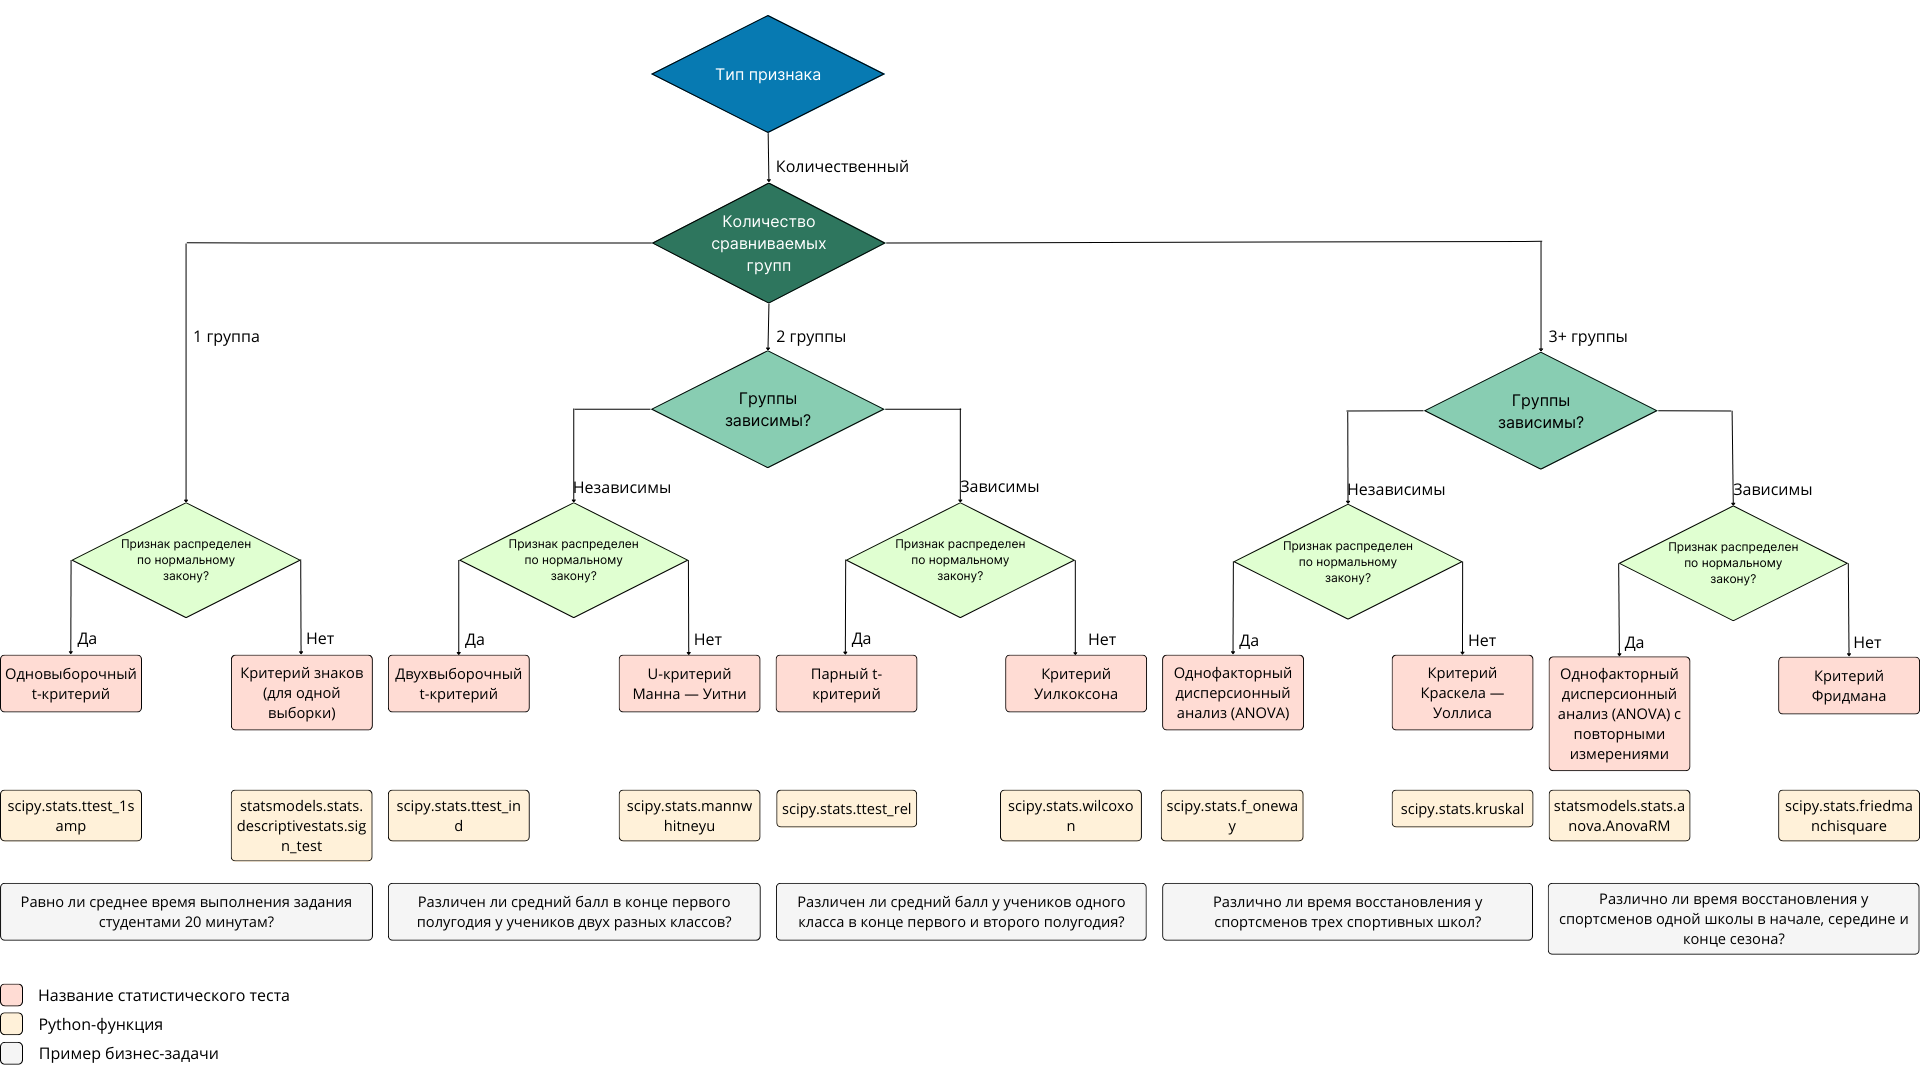

Например, время, проведённое на сайте, часто бывает нормально распределённым. Тогда мы можем использовать двухвыборочный T-критерий для средних. А вот денежные метрики, такие как средний чек, часто (но не всегда) напоминают логнормальное распределение: большинство наблюдений сосредоточены около нуля, и частота постепенно падает.

Напомним, что для проверки распределения на нормальность мы всегда можем воспользоваться самым популярным и знакомым нам тестом Шапиро — Уилка или любым другим, например, тестом Д’Агостино K2.

# ПАРАМЕТРИЧЕСКИЕ ТЕСТЫ

Давайте рассмотрим пример.

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательна для посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 0.05.

Результаты тестирования представлены в этом файле.

In [ ]:
time_data = pd.read_excel('/content/drive/MyDrive/Data/asset-v1_SkillFactory+DST-3.0+28FEB2021+type@asset+block@time_data.xlsx')
display(time_data.head())

Для начала сравним среднее время в группах на глаз. Рассчитаем среднее и медианное время в каждой группе:

In [ ]:
time_data[['time(A)', 'time(B)']].agg(['mean', 'median'])

По предварительным подсчётам, среднее время, проводимое на сайте, в группе B выше, чем в группе A. Однако делать выводы ещё рано — необходимо определить статистическую значимость полученных результатов.

Затем построим гистограмму времени, которое провели на сайте пользователи в каждой из групп:

In [ ]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро — Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

In [ ]:
from scipy.stats import shapiro

Зададим уровень значимости  и проверим гипотезу о нормальности каждого из распределений (нулевая гипотеза — распределение нормальное, альтернативная — распределение отлично от нормального):

In [ ]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")

# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределение в группе А является нормальным
# Принимаем нулевую гипотезу. Распределение в группе B является нормальным

Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом, чтобы сравнить среднее время посещения сайта в группах.

Напомним формулировки статистических гипотез для T-теста:

Нулевая гипотеза (об отсутствии эффекта): среднее время, которое проводят на сайте пользователи из группы А, равно среднему времени, которое проводят на сайте пользователи из группы B:


Альтернативная гипотеза (о наличии эффекта): среднее время, которое проводят на сайте пользователи из группы А, отличается от среднего времени, которое проводят на сайте пользователи из группы B:


Примечание. Ещё раз обратите внимание на то, что именно альтернативная гипотеза отвечает на бизнес-вопрос «Увеличилось ли время, которое пользователь проводит на сайте, после внедрения варианта B?».

Применим двухвыборочный T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats.

In [ ]:
from scipy.stats import ttest_ind

Функция принимает на вход следующие параметры:

a и b — выборки, соответствующие каждой из групп.
alternative — вид альтернативной гипотезы (‘two-sided’ — двусторонняя, 'less' — левосторонняя, 'greater’ — правосторонняя). По умолчанию используется двусторонняя гипотеза.

In [ ]:
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value: 0.0
# Отвергаем нулевую гипотезу в пользу альтернативной

Итак, в результате проведения T-теста мы получили p-value = 0, что меньше, чем уровень значимости . Это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной.

Что это значит для нас и для бизнеса?

Так как истинные значения конверсий в группах не равны (с уровнем значимости 0.05), то для нас это значит, что альтернативная гипотеза подтверждается статистически.

Переводим на язык бизнеса: существует разница между вариантами дизайна сайта по метрике времени, которое пользователь проводит на сайте. На основе данных мы видим, что тёмная тема более привлекательна для посетителей, чем светлая.

Обратите внимание: так как при двусторонней гипотезе p-value = 0, не нужно проверять одностороннюю гипотезу о том, что среднее время, которое проводят на сайте пользователи из группы A, меньше, чем среднее время для пользователей из группы B. Мы можем сделать итоговый вывод об этом только на основе данных, ведь мы доказали статистическую значимость разницы в метриках. Однако при желании вы можете проверить одностороннюю гипотезу самостоятельно — для этого в функции установите параметр alternative='less'.

# НЕПАРАМЕТРИЧЕСКИЕ ТЕСТЫ

Давайте рассмотрим ещё один пример.

Мы проводим A/B-тест, чтобы оценить, влияет ли наличие рекомендательной системы сопутствующих товаров на средний чек покупки. Гипотеза заключается в том, что рекомендательная система мотивирует пользователей, помимо основных товаров, добавлять в покупку сопутствующие, тем самым повышая средний чек. Уровень значимости равен 0.05.

Результаты тестирования представлены в этом файле.

In [ ]:
check_data = pd.read_excel('/content/drive/MyDrive/Data/asset-check_data.xlsx')
check_data.head()

В данных содержится информация о значениях ежедневного среднего чека в группах A и B. Период проведения A/B-тестирования — 18 дней.

Сначала сравним среднее время в группах на глаз. Рассчитаем среднее и медианное время в каждой группе:

In [ ]:
check_data[['mean_check_a', 'mean_check_b']].agg(['mean', 'median'])

По предварительным подсчётам, ежедневный средний чек в группе B выше, чем в группе A. Однако делать выводы ещё рано — необходимо определить статистическую значимость полученных результатов.

Построим гистограмму ежедневного среднего чека в каждой из групп:

In [ ]:
# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean_check_a', data=check_data, ax=axes[0])
sns.histplot(x='mean_check_b', data=check_data, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Распределения не являются нормальными. Можно проверить это с помощью теста Шапиро — Уилка, однако мы опустим этот шаг (при желании вы можете сделать это самостоятельно). Формы распределений больше напоминают логнормальные: большинство наблюдений сосредоточено около нуля, и частота постепенно падает.

Итак, поскольку данные не распределены нормально, для сравнения истинных средних чеков T-тест уже нё подойдет. Здесь нам придётся обратиться к непараметрическим тестам, например, к критерию Манна — Уитни (U-тест), критерию Колмогорова — Смирнова и другим. Напомним, что эта категория тестов применяется в случаях, когда нет информации о распределении.

Примечание о критерии Манна — Уитни:

Постоянно ведутся споры о том, целесообразно ли при A/B-тестировании применять критерий Манна — Уитни, чтобы проверить, является ли статистически значимой разница в метриках между группами A и B.

Часто в учебных материалах для начинающих дата-сайентистов и аналитиков говорится, что критерий Манна — Уитни — это непараметрический аналог T-теста, и вместо сравнения средних он определяет разницу между медианами. Однако это не совсем так, почему — отлично показано в статье Дмитрия Лунина, аналитика из «Авито». Мы настоятельно рекомендуем вам ознакомиться с ней, если вы хотите лучше понять тонкости применения статистических тестов при обработке результатов A/B-тестирования.

Основные идеи этой статьи:

* Критерий Манна — Уитни не проверяет равенство средних или медиан в группах. Он позволяет убедиться, что выборки из контрольной и тестовой групп соответствуют одному и тому же распределению, то есть проверяет наличие (отсутствие) сдвига между распределениями. Например, если тестовая выборка имеет распределение , а тестовая — , то тест будет проверять нулевую гипотезу  против альтернативной .
* Пытаясь использовать критерий Манна — Уитни для установления равенства средних/медиан при A/B-тестировании, вы повышаете вероятность возникновения ошибки I рода более чем в два раза.
Критерий Манна — Уитни чаще, чем T-тест, завышает вероятность наличия эффекта в данных, что может привести к искажению результатов A/B-тестирования.
* Применение логарифмирования или других трансформаций к целевой метрике не поможет уменьшить ошибку U-теста.
*Для реальных задач A/B-тестирования критерий Манна — Уитни стоит использовать с осторожностью, подкрепляя его результаты другими статистическими тестами.

В учебных целях мы будем использовать U-критерий Манна — Уитни для случаев, когда метрики не распределены нормально. Однако при этом будем помнить, что результатам этого критерия при p-value, близким к уровню значимости, доверять не стоит.

Давайте воспользуемся тестом Манна — Уитни, чтобы проверить, статистически значима ли разница ежедневных средних чеков для двух вариантов рекомендательной системы.

Для критерия Манна — Уитни гипотезы будут выглядеть следующим образом:

Нулевая гипотеза (об отсутствии эффекта): распределение, лежащее в основе среднего чека в группе А, идентично распределению, лежащему в основе среднего чека в группе B:


Альтернативная гипотеза (о наличии эффекта): распределение, лежащее в основе среднего чека в группе А, отлично от распределения, лежащего в основе среднего чека в группе B:

Напомним, что U-тест Манна — Уитни реализован в функции mannwhitneyu() из модуля scipy.stats.

In [ ]:
from scipy.stats import mannwhitneyu

Функция принимает на вход следующие параметры:

x и y — выборки, соответствующие каждой из групп.
alternative — вид альтернативной гипотезы (‘two-sided’ — двусторонняя, 'less' — левосторонняя, 'greater’ — правосторонняя). По умолчанию используется двусторонняя гипотеза.

In [ ]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value: 0.06
# У нас нет оснований отвергнуть нулевую гипотезу

Итак, согласно результатам тестирования, p-value = 0.06, что больше, чем уровень значимости . Значит, у нас нет оснований отвергнуть нулевую гипотезу.

Что это значит для нас и для бизнеса?

Средние чеки в группах А и B статистически равны между собой. Отсюда можно сделать бизнес-вывод, что рекомендательная система не влияет на мотивацию пользователей добавлять сопутствующие товары в корзину.

Однако нас должно насторожить, что p-value очень близко к уровню значимости. Поэтому давайте дополнительно проведём односторонний U-тест со следующими гипотезами:

Нулевая гипотеза (об отсутствии эффекта): распределение, лежащее в основе среднего чека в группе А, статистически больше либо равно распределению, лежащему в основе среднего чека в группе B:


Левосторонняя альтернативная гипотеза (о наличии эффекта): распределение, лежащее в основе среднего чека в группе А, статистически меньше распределения, лежащего в основе среднего чека в группе B:

In [ ]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=check_data['mean_check_a'],
    y=check_data['mean_check_b'],
    alternative='less' # изменили альтернативную гипотезу
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

# p-value: 0.03
# Отвергаем нулевую гипотезу в пользу альтернативной

Получаем значение p-value = 0.03, что меньше, чем уровень значимости . Значит, мы должны отвергнуть нулевую гипотезу в пользу альтернативной. Таким образом, односторонний тест говорит нам, что разница в средних чеках всё-таки статистически значима. То есть рекомендательная система всё-таки мотивирует пользователей добавлять сопутствующие товары в корзину и повышает средний чек, а значит, её можно внедрять для всех пользователей сайта.

Итак, мы получили два противоречивых вывода: двусторонний тест говорит, что эффекта нет, а односторонний — что есть. Какой вывод правильный?

Ответ:

На самом деле никакой. Когда двусторонний и односторонний тесты противоречат друг другу, это, скорее всего, означает, что данные неоднозначны и нужно более внимательно исследовать результаты тестирования.

В такой ситуации для более точной оценки эффекта можно попробовать провести анализ данных с помощью других методов и моделей. Также стоит обратить внимание на размер выборки, возможные выбросы, несбалансированность групп, а также на то, были ли учтены все факторы, которые могут влиять на результаты тестирования.

В нашем случае очевидной проблемой является размер выборки, а точнее длительность A/B-теста. Замеры среднего чека сделаны только за 18 дней, что очень мало. Размер выборки играет важную роль, особенно при применении непараметрических тестов (каким является тест Манна — Уитни), которые обладают меньшей мощностью, чем параметрические, а потому требуют большего количества наблюдений.

Таким образом, в данном случае мы не можем принять решение о внедрении или невнедрении рекомендательной системы, так как у нас попросту недостаточно данных, чтобы сделать вывод. Необходимо продолжить A/B-тестирование, чтобы получить однозначные результаты.